# Examples for Black Box Variational Inference

In [1]:
%matplotlib inline

In [20]:
import daft
import numpy as np
import scipy.stats
import sklearn.datasets
import tensorflow as tf

import matplotlib.pyplot as plt

from chmp.ds import Loop, expand, mpl_set

## LogNormal Implementation

In [3]:
# MOVE into chmp.ml
class LogNormal(tf.contrib.distributions.TransformedDistribution):
    def __init__(self, loc, scale, name=None):
        super().__init__(
            distribution=tf.distributions.Normal(loc=loc, scale=scale),
            bijector=tf.contrib.distributions.bijectors.Exp(),
            name=name
        )
        
    def entropy(self):
        return (
            0.5 * tf.log(2.0 * np.pi) +
            tf.log(self.distribution.scale) +
            self.distribution.loc + 0.5
        )

In [4]:
# Check log normal entropy
tf.reset_default_graph()

px_ = LogNormal(loc=[0., 1., 2.], scale=[1., 2., 3.])
entropy_mc_ = tf.reduce_mean(-px_.log_prob(px_.sample(5000)), axis=0)
entropy_ = px_.entropy()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print('exact  ', sess.run(entropy_))
    print('MC est.', sess.run(entropy_mc_))

exact   [1.4189385 3.1120858 4.517551 ]
MC est. [1.4413662 3.1586006 4.491992 ]


## Gamma-Normal

$$
\begin{aligned}
    \tau &\sim \mathrm{Gamma}(\tau|\alpha, \beta) 
        = \frac{\beta^\alpha}{\Gamma(\alpha)} \tau^{\alpha - 1} exp \left[-\beta \tau\right]
\\
    x &\sim \mathrm{N}(x|0, \tau^{-1}) 
        = \sqrt{\frac{\tau}{2 \pi}} \exp \left[ - \frac{1}{2} \tau x^2 \right] 
\end{aligned}
$$

Note by normalization of the Gamma distribution:

$$
\begin{aligned}
    \int_0^\infty \mathrm{d}\tau\; \tau^{\alpha - 1} e^\left[-\beta \tau\right] 
        = \frac{\Gamma(\alpha)}{\beta^\alpha}
\end{aligned}
$$

Posterior:

$$
\begin{aligned}
    p(\tau|\{x\}) &\propto p(\{x\}|\tau) p(\tau) 
\\
    &= \tau^{\alpha - 1} e^{-\beta \tau} \sqrt{\tau} \exp \left[ - \frac{1}{2} \tau x^2 \right] 
\\
    &= \tau^{\alpha + \frac{1}{2} n_i - 1} exp \left[ -(\beta + \sum_i x_i^2) \tau \right]
\\
    p(\tau|\{x\}) &= \mathrm{Gamma}(\tau | \alpha^\prime, \beta^\prime)
\end{aligned}
$$

with

$$
\begin{aligned}
    \alpha^\prime &= \alpha + \frac{1}{2} n_i
\\
    \beta^\prime &= \beta + \sum_i x_i^2
\end{aligned}
$$

Posterior predictive:

$$
\begin{aligned}
    p(x^\prime| \{x\}) 
        &= \int_0^\infty \mathrm{d}\tau\; p(x^\prime|\tau) p(\tau|\{x\}) \\
        &= \int_0^\infty \mathrm{d}\tau\; 
            \mathrm{N}(x|0, \tau^{-1}) 
            \mathrm{Gamma}(\tau | \alpha^\prime, \beta^\prime) \\
        &= \int_0^\infty \mathrm{d}\tau\; 
            \sqrt{\frac{\tau}{2 \pi}} \exp \left[ - \frac{1}{2} \tau x^2 \right] 
            \frac{{\beta^\prime}^{\alpha^\prime}}{\Gamma(\alpha^\prime)} 
            \tau^{\alpha^\prime - 1} exp \left[-\beta^\prime \tau\right] \\
        &=
            \frac{{\beta^\prime}^{\alpha^\prime}}{\sqrt{2 \pi}\Gamma(\alpha^\prime)} 
            \int_0^\infty \mathrm{d}\tau\; 
            \tau^{\alpha^\prime + \frac{1}{2} - 1} 
            exp \left[-\left( \beta^\prime + \frac{1}{2} x^2 \right) \tau\right] \\
        &= 
            \frac{{\beta^\prime}^{\alpha^\prime}}{\sqrt{2 \pi}\Gamma(\alpha^\prime)} 
            \Gamma(\alpha^\prime + \frac{1}{2})
            \left( \beta^\prime + \frac{1}{2} x^2 \right)^{-\frac{2 \alpha^\prime + 1}{2}} \\
        &= 
            \frac{1}{\sqrt{2 \pi \beta^{\prime}}}
            \frac{\Gamma(\alpha^\prime + \frac{1}{2})}{\Gamma(\alpha^\prime)} 
            \left( 1 + \frac{1}{2 \beta^\prime} x^2 \right)^{-\frac{2 \alpha^\prime + 1}{2}} \\
        &= 
            \frac{1}{\sqrt{\pi \nu s^2}} 
            \frac{\Gamma(\frac{\nu + 1}{2})}{\Gamma(\frac{\nu}{2})} 
            \left( 1 + \frac{1}{\nu} \frac{x^2}{s^2} \right)^{-\frac{\nu + 1}{2}} \\
        &=
            \mathrm{StudentT}(x|\nu, s)
\end{aligned}
$$

with

$$
\begin{aligned}
    \nu &= 2 \alpha^\prime \\
    s^2 &= \frac{2 \beta^\prime}{\nu} = \frac{\beta^\prime}{\alpha^\prime}
\end{aligned}
$$

In [5]:
df = 10
sigma = 2.0

x = sigma * np.random.standard_t(df, size=200)

In [10]:
tf.reset_default_graph()

x_ = tf.placeholder(tf.float32, [None])

qtau_inv_mu_ = tf.Variable(0.0) 
qtau_inv_sigma_ = tf.nn.softplus(tf.Variable(1.0))

qtau_inv_ = LogNormal(qtau_inv_mu_, qtau_inv_sigma_)

tau_inv_ = qtau_inv_.sample()
px_ = tf.distributions.Normal(0.0, tf.sqrt(1e-4 + tau_inv_))

ptau_inv_ = tf.contrib.distributions.InverseGamma(1.0, 1.0)

loss_ = (
    tf.reduce_sum(px_.log_prob(x_)) + 
    tf.reduce_sum(ptau_inv_.log_prob(tau_inv_)) + 
    tf.reduce_sum(qtau_inv_.entropy())
) / tf.cast(tf.size(x_), tf.float32)

train_ = tf.train.AdamOptimizer(1e-3).minimize(-loss_)

In [46]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    losses = []

    for loop, idx in Loop.over(range(10_000)):
        _, loss = sess.run([train_, loss_], {x_: x})
        if (idx % 100) == 0:
            losses += [loss]
        
        loop.print(f'{loop} {loss:.4f}')
        
    tau_inv = sess.run(qtau_inv_.sample(1000))

[⣿⣿⣿▫▫▫▫▫▫▫ 4.13s / 13.68s] -5.9829                                                                                     

[⣿⣿⣿⣿⣿▫▫▫▫▫ 6.96s / 14.17s] -2.4158                                                                                     

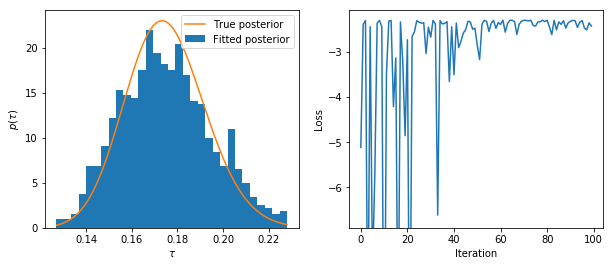

In [47]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

plt.sca(ax1)
alpha_post = 1.0 + 0.5 * len(x)
beta_post = 1.0 + 0.5 * np.sum(x ** 2.0)
posterior_true = scipy.stats.gamma(alpha_post, 0, 1.0 / beta_post)

x_low, x_high = expand(posterior_true.ppf(0.01), posterior_true.ppf(0.99), 0.50)

u = np.linspace(x_low, x_high, 500)
plt.hist(1.0 / alpha_inv, bins=31, range=(x_low, x_high), density=True, label='Fitted posterior')
plt.plot(u, posterior_true.pdf(u), label='True posterior')

mpl_set(xlabel=r'$\tau$', ylabel=r'$p(\tau)$', legend=True)

plt.sca(ax2)
loss_low, loss_high = expand(*np.percentile(losses, [5, 95]), 0.20)
plt.plot(losses)
mpl_set(xlabel='Iteration', ylabel='Loss', ylim=(loss_low, loss_high))
pass